In [17]:
import torch
from data_handler import DataHandler, load_encoded_data, create_dataset
from model import TravelDocClassifier
from cuda_utils import clear_cache, print_cuda_memory_info

In [18]:
clear_cache()
print_cuda_memory_info()

Device: NVIDIA GeForce RTX 4070 SUPER
Total Memory: 12.88 GB
Reserved Memory: 0.47 GB
Allocated Memory: 0.42 GB
Free Memory: 0.05 GB


### Testing

In [19]:
data_handler = DataHandler(tokenizer_name='bert-base-chinese')

encodings = load_encoded_data('encoded_data/test/encodings_256')
labels = load_encoded_data('encoded_data/test/labels')

test_dataset = create_dataset(encodings, labels)

In [20]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

classifier = TravelDocClassifier(device=device, params_path='parameters/20240603_95_model_parameters.pth')
test_accuracy, confusion = classifier.test(test_dataset)

print(f"Test Accuracy: {test_accuracy:.2f}%")
print("Confusion Matrix:")
print(confusion)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-chinese and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Test Accuracy: 0.95%
Confusion Matrix:
[[2617  271]
 [ 259 7556]]


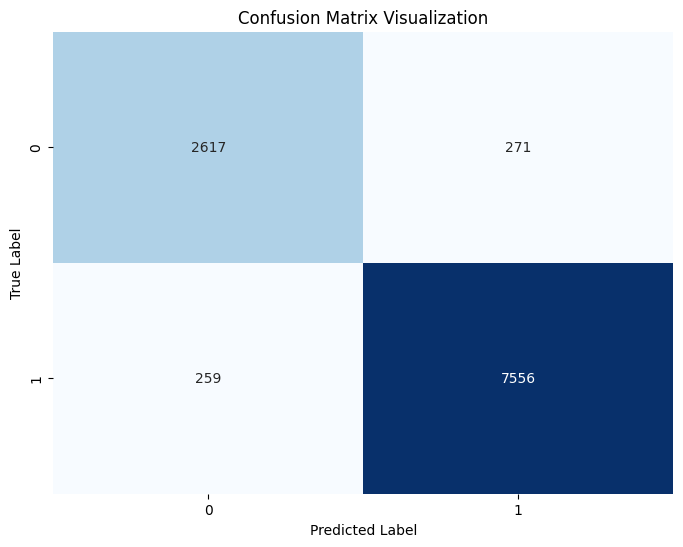

In [21]:
import matplotlib.pyplot as plt
import seaborn as sns

# 使用 Seaborn 的 heatmap 函數來創建熱力圖
plt.figure(figsize=(8, 6))
sns.heatmap(confusion, annot=True, fmt="d", cmap="Blues", cbar=False)

# 加入標籤和標題
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix Visualization')
plt.show()

In [22]:
tp, fn, fp, tn = confusion.ravel()

# 精確率 (Precision)
precision = tp / (tp + fp)

# 召回率 (Recall)
recall = tp / (tp + fn)

# 特異性 (Specificity)
specificity = tn / (tn + fp)

# F1 Score
f1_score = 2 * (precision * recall) / (precision + recall)

print(f"精確率 (Precision): {precision:.4f}")
print(f"召回率 (Recall): {recall:.4f}")
print(f"特異性 (Specificity): {specificity:.4f}")
print(f"F1 Score: {f1_score:.4f}")

精確率 (Precision): 0.9099
召回率 (Recall): 0.9062
特異性 (Specificity): 0.9669
F1 Score: 0.9080
